## Preparation

In [158]:
# Install Numerai's API
# %pip install numerapi -U
%pip install yfinance

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 1.0 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 10.0 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for lxml: filename=lxml-4.9.2-cp39-cp39-macosx_11_0_arm64.whl size=1567556 sha256=071acf51b0430a236265f45b685f076a58fd3af298a7359690e67a21d2b0bd6b
  Stored in directory: /Users/janghyeonjae/Library/Caches/pip/wheels/8f/56/1e/db8cce7999c23b8807710529c758de5b57d4ed95d8098e147b
Successfully built lxml
Note: you may need to restart the kernel to use upd

In order to access Stock News API and the Numerai Signals API we need to set up private keys. 

1. To get the Stock News API key sign up [here (14-day free trail)](https://stocknewsapi.com/).
2. To get the Numerai Signals API keys go to [signals.numer.ai/tournament](https://signals.numer.ai/tournament) -> Log in/Sign up for an account -> select "Account" in the top-right -> "Settings" -> "Automation". From here you can create an API Key for NumerAPI.

In [1]:
# Obfuscated API keys

# API Key for Stock News API
STOCK_NEWS_API_TOKEN = "kfsjtbyvhwrywla9vp7fwcobwipvucm4qwrh8cpz"

# API settings for submitting to Numerai
NMR_PUBLIC_ID = "IFWJNC6Y5VEEMFYI35PJ3Y6YBRDGUMIR"
NMR_SECRET_KEY = "HLIIRWEI6MJN33GGGQ3IUFRJANRSWTIKHMO3JPJDHUKAQBGJYB423CSBJ6QJYAGL"
MODEL_NAME = "Compute"


In [2]:
import os
import ast
import torch
import pickle
import requests
import numpy as np
import random as rn
import pandas as pd
from tqdm.notebook import tqdm
from datetime import datetime
from typing import Tuple, List
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta, FR
from yfinance import Ticker, Tickers
import json
# Machine Learning
import torch.nn.functional as F
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Numerai's API
import numerapi

# Core data paths
MODEL_PATH = "ipuneetrathore/bert-base-cased-finetuned-finBERT"
TICKER_PATH = "https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv"
NEWS_DATA_PATH = "news_data.csv"
SUB_PATH = "finbert_submission.csv"

# Model inference parameters
MAX_LEN = 256
BATCH_SIZE = 8

# Set seed for reproducability
seed = 5321
rn.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Surpress Pandas warnings
pd.set_option('chained_assignment', None)


### Data loading using Stock News API

Stock News API has news articles on 1000s of stocks. Some may or may not be relevant for the Numerai Signals tournament. We therefore compute the intersection of Stock News API tickers and Numerai Signals Tickers:

$$relevant\_tickers = stock\_news\_tickers \cap numerai\_tickers$$

In [3]:
relevant_tickers = set(["TSLA", "AAPL", "DIS", "GE", "BRK-B", "NKE", "SBUX", "SSNLF", "AMZN", "META", "GOOGL", "BRK-A", "MSFT", "TSM",
                       "UNH", "JNJ", "WMT", "NVDA", "PG", "AMD", "JPM", "XOM", "MA", "CVX", "HD", "BAC", "PFE", "LLY", "ABBY", "KO", "NVO", "BABA", "PEP", "TM", "ASML", "COST", "VZ", "TMO", "MRK", "ORCL", "AVGO", "ABT", "NVS", "ACN", "DHR", "BHP", "AZN", "MCD", "CRM", "WFC", "CSCO", "BMY", "UPS", "LIN", "QCOM", "LMT", "NFLX", "ADBE", "INTC"])

# tickers = pd.read_csv(TICKER_PATH)
# numerai_tickers = set(tickers["ticker"].values)

# relevant_tickers = list(set(stock_news_tickers).intersection(numerai_tickers))


In [4]:
print(
    f"There are a total of {len(relevant_tickers)} intersecting stock tickers.")

There are a total of 59 intersecting stock tickers.


In [135]:
class StockNewsAPILoader:
    """
    Data loader for Stock News API: https://stocknewsapi.com
    :param token: API Key for Stock News API
    """

    def __init__(self, token: str):
        self.domain = "https://stocknewsapi.com/api/v1"
        self.token = token

        # Safety parameter to limit unnecessary API calls
        # Retrieving all news articles for a ticker requires on average 2 API calls
        self.page_cutoff_point = 3

    def get_last_week_news(self, ticker: str) -> pd.DataFrame:
        """
        Get all news for a ticker from last week (monday to friday)

        :param ticker: Valid ticker symbol for stocknewsAPI
        :return: Pandas DataFrame containing all data for ticker in the past week
        """
        i = 1
        dfs = []
        while i <= self.page_cutoff_point:
            api_request = f"{self.domain}?tickers={ticker}&items=20&type=article&page={i}&sortby=rank&days=7&token={self.token}"
            r = requests.get(api_request)
            if r.status_code != 200:
                break
            json_request = r.json()
            if not json_request.get('data'):
                break
            df = pd.DataFrame(json_request)
            if df.empty:
                break
            dfs.append(df)
            i += 1
        if not dfs:
            return pd.DataFrame()
        final_df = pd.concat(dfs)
        return final_df

    def get_last_week_news_multiple_tickers(self, tickers: list) -> pd.DataFrame:
        dfs = []
        process = tqdm(tickers)
        for t in process:
            df = self.get_last_week_news(t)
            if not df.empty:
                dfs.append(df)
            process.set_postfix(collected=len(dfs))
        if not dfs:
            raise ValueError('The data is not collected')
        final_df = pd.concat(dfs)
        return final_df


In [136]:
# Retrieve data from API
snl = StockNewsAPILoader(STOCK_NEWS_API_TOKEN)
data = snl.get_last_week_news_multiple_tickers(relevant_tickers)
data.to_csv(NEWS_DATA_PATH, index=False)


  0%|          | 0/59 [00:00<?, ?it/s]

ValueError: No objects to concatenate

### Data Wrangling

To prepare the data for sentiment analysis predictions we go through a series of steps. At a high level the following preprocessing operations are performed:
1. Remove unnecessary columns ('text', 'news_url', 'image_url', 'topics' and 'source_name')
2. Keep only API calls with the "Article" type. 
3. Filter all articles with "Neutral" sentiment.
4. Convert all timestamp to UTC (Coordinated Universal Time) so all rows have a common datetime format.

By aggregating all news headlines that refer to a ticker we get a row for each ticker and the headlines separated by a $[SEP]$ token, which we will use to batch our news headline input. Lastly, we merge the new DataFrame on the Numerai tickers to retrieve a Bloomberg ticker format that we need later in the submission step.

In [5]:

class StockNewsProcessor:
    """
    Preprocessor for Stock News API output
    https://stocknewsapi.com
    """

    def __init__(self, relevant_tickers=list):
        self.tickers = pd.read_csv(TICKER_PATH)
        self.unnecessary_cols = ['text', 'news_url',
                                 'image_url', 'source_name']
        self.text_cols = ['title']
        self.relevant_tickers = relevant_tickers

    def preprocess(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Data cleaning for Stock News API data

        :param data: A raw Pandas DataFrame containing at least the columns 'type', 'sentiment', 'date' and
                    columns specified in self.unnecessary_cols.
        :return: A clean and sorted DataFrame with date as index.
        """
        data = data.drop(self.unnecessary_cols, axis=1)
        data = data.drop_duplicates()
        data['tickers'] = data['tickers'].apply(
            lambda s: list(ast.literal_eval(s)))
        data = data.drop('type', axis=1)

        data = data[data['sentiment'] != "Neutral"]
        data = data.drop('sentiment', axis=1)

        data['date'] = data['date'].apply(
            lambda x: pd.to_datetime(x).tz_convert('UTC'))
        data['topics'] = data['topics'].apply(lambda x: list(ast.literal_eval(x)))
        data = data.set_index(data['date'], drop=True).sort_index()
        print(data.index)
        return data

    def aggregate(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Combine weekly text and order by Friday date

        :param data: A preprocessed DataFrame
        :return: Data grouped by ticker and friday dates
        """
        for col in self.text_cols:
            data.loc[:, col] = data[col] + " [SEP] "

        dfs = []
        for ticker in tqdm(self.relevant_tickers):
            aggregated = data[data['tickers'].apply(
                lambda x: ticker in x)].resample("W-fri", on='date').sum()
            aggregated = aggregated.drop("tickers", axis=1)
            aggregated['ticker'] = ticker
            aggregated = aggregated.drop_duplicates("ticker", keep='last')
            if aggregated.empty:
                continue
            dfs.append(aggregated)
        new_df = pd.concat(dfs)
        
        new_df['title'] = new_df['title'].astype(str)
        # merged = new_df.merge(self.tickers, on='ticker')
        # merged = merged.drop("yahoo", axis=1).dropna()
        return new_df

    def full_preprocessing(self, data: pd.DataFrame) -> pd.DataFrame:
        """
        Reads in API data and makes it ready for further analysis

        :param data: Pandas DataFrame generated with stocknewsapi_loader
        :return: Data grouped by ticker and friday dates
        """
        proc_data = self.preprocess(data)
        agg_data = self.aggregate(proc_data)
        agg_data['topics'] = agg_data['topics'].apply(set)
        return agg_data


In [6]:
# Process and aggregate collected data
raw_data = pd.read_csv(NEWS_DATA_PATH)
snp = StockNewsProcessor(relevant_tickers)
proc_data = snp.full_preprocessing(raw_data)


KeyError: "['text', 'news_url', 'image_url', 'source_name'] not found in axis"

In [146]:
print("Preprocessed rows:")
proc_data.head()


Preprocessed rows:


,title,ticker
date,,
2022-11-18 00:00:00+00:00,The 7 Most Undervalued Value Stocks to Buy Now...,DHR
2022-11-18 00:00:00+00:00,"Diagonal Spread Could Net Around $1,000 If Net...",NFLX
2022-11-18 00:00:00+00:00,A Berkshire Hathaway Bright Spot: Energy. Here...,BRK-B
2022-11-18 00:00:00+00:00,Up 15% In A Month Will Bristol Myers Squibb St...,BMY
2022-11-18 00:00:00+00:00,Weak Gaming Chip Demand to Hurt NVIDIA (NVDA) ...,NVDA


In [130]:
sample = proc_data.iloc[0]
print(f"Example of aggregated headlines for '{sample['ticker']}' stock:\n")
print(sample['title'])


Example of aggregated headlines for 'DHR' stock:

The 7 Most Undervalued Value Stocks to Buy Now [SEP] Danaher (DHR) Just Reclaimed the 200-Day Moving Average [SEP] 


### FinBERT Inference

This class predicts sentiment score on the aggregated weekly data we have prepared for every ticker. The output of FinBERT is a softmax activation over three classes ('negative', 'neutral' and 'positive'). Our sentiment score will be the probability of positive sentiment minus the probability of negative sentiment. There may be multiple news articles written about a ticker in a given week so we take the mean of all predictions for a ticker.


$$Pred(T) = \frac{1}{n} \sum_{i=1}^{n} positive_i - negative_i$$

where $T$ denotes a specific stock ticker and $n$ the total amount of headlines.


In [131]:
class FinBertCased:
    def __init__(self, max_len: int, batch_size: int, model_path: str, device: str = "cuda"):
        self.max_len = max_len
        self.model_path = model_path
        self.batch_size = batch_size
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_path)
        self.device = device
        self.model = AutoModelForSequenceClassification.from_pretrained(
            self.model_path).eval().to(device)
        self.label_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
        self.inverse_label_dict = {v: k for k, v in self.label_dict.items()}

    def full_preprocess(self, text: List[str]) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Preprocessing pipeline from string to ids and attention mask. """
        encoded = self.tokenizer(text,
                                 add_special_tokens=True,
                                 max_length=self.max_len,
                                 padding='max_length',
                                 return_attention_mask=True,
                                 return_tensors='pt',
                                 truncation=True)
        input_ids = torch.cat([encoded['input_ids']], dim=0).to(self.device)
        attention_mask = torch.cat(
            [encoded['attention_mask']], dim=0).to(self.device)
        return input_ids, attention_mask

    def predict_raw(self, text: List[str]) -> torch.Tensor:
        """ Predict raw logits """
        input_ids, attention_mask = self.full_preprocess(text)
        model_output = self.model(
            input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = model_output[0]
        return logits

    def predict_score(self, text: List[str]) -> np.float32:
        """ Predict a single sentiment score (positive_sentiment - negative_sentiment) """
        logits = self.predict_raw(text)
        softmax_output = F.softmax(logits, dim=1).cpu().detach().numpy()
        pos_idx = self.inverse_label_dict['positive']
        neg_idx = self.inverse_label_dict['negative']
        return softmax_output[:, pos_idx] - softmax_output[:, neg_idx]

    def predict_signals(self, text: pd.Series) -> List[float]:
        """
        Get ranking of average sentiment scores for every ticker in the data.
        :param text: Pandas Series of articles grouped by week and ticker
        :return: Scaled sentiment scores in range [0...1]
        """
        sent_scores = []
        sent_length = []
        for row in tqdm(text):
            sents = row.split(" [SEP] ")[:-1]
            sent_length.append(len(sents))
            sent_scores_ticker = []
            for batch in self._chunks(sents, self.batch_size):
                batch_sents = self.predict_score(batch)
                sent_scores_ticker.append(batch_sents)
            mean_score = np.array(np.concatenate(
                sent_scores_ticker)).ravel().mean()
            sent_scores.append(mean_score)
        signals = self._scale_sentiment(sent_scores)
        return signals, sent_length

    @staticmethod
    def _chunks(lst, n):
        """ Yield successive n-sized chunks from list. """
        for i in range(0, len(lst), n):
            yield lst[i:i + n]

    @staticmethod
    def _scale_sentiment(sentiments: List[float]):
        """ Scale sentiment scores from [-1...1] to [0...1] """
        mm = MinMaxScaler()
        sent_proc = np.array(sentiments).reshape(-1, 1)
        return mm.fit_transform(sent_proc)


In [132]:
import platform as pl
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = "cuda"
if pl.system() == "Darwin":
    DEVICE = "mps"
# Predict signals for all preprocessed data
fbc = FinBertCased(max_len=MAX_LEN, batch_size=BATCH_SIZE,
                   model_path=MODEL_PATH, device=DEVICE)
proc_data.loc[:, 'signal'], proc_data['amount'] = fbc.predict_signals(proc_data['title'])


  0%|          | 0/58 [00:00<?, ?it/s]

In [ ]:
proc_data['trust_rate'] = proc_data['amount']/proc_data['amount'].sum() * 100
proc_data['score'] = proc_data['trust_rate'] * proc_data['signal']

In [ ]:
print("Some of the predictions made by FinBERT:")
proc_data[['title', 'ticker', 'topics', 'signal', 'trust_rate', 'score']].sort_values(
    by='score', ascending=False)


Some of the predictions made by FinBERT:


,title,ticker,topics,signal,trust_rate,score
date,,,,,,
2022-11-18 00:00:00+00:00,Three Retail Earnings to Watch for Next Week [...,WMT,['earnings'][]['paylimitwall'][]['earnings']['...,0.516342,7.205240,3.720366
2022-11-18 00:00:00+00:00,Investors Heavily Search Taiwan Semiconductor ...,TSM,"[]['wbuffett']['wbuffett']['wbuffett', 'paylim...",0.513885,5.895197,3.029454
2022-11-18 00:00:00+00:00,3 Stocks You'll Be Glad You Bought at These Pr...,GOOGL,[]['paylimitwall'][]['podcast'][][][][][]['Pol...,0.459206,6.331878,2.907638
2022-11-18 00:00:00+00:00,A Berkshire Hathaway Bright Spot: Energy. Here...,BRK-A,['paywall']['wbuffett']['wbuffett']['wbuffett'...,0.460224,4.803493,2.210685
2022-11-18 00:00:00+00:00,A Berkshire Hathaway Bright Spot: Energy. Here...,BRK-B,['paywall']['wbuffett']['wbuffett']['wbuffett'...,0.460224,4.803493,2.210685
2022-11-18 00:00:00+00:00,Elon Musk's Tesla Pay Package Goes To Trial Mo...,TSLA,['CEO'][][][]['paylimitwall'][][][][][]['CEO']...,0.279220,5.895197,1.646058
2022-11-18 00:00:00+00:00,Three Retail Earnings to Watch for Next Week [...,HD,['earnings'][][]['earnings']['paylimitwall'][]...,0.326586,4.366812,1.426138
2022-11-18 00:00:00+00:00,7 No-Brainer Blue-Chip Stocks to Buy for 2023 ...,AAPL,[]['wbuffett'][]['paywall']['paylimitwall']['d...,0.335427,4.148472,1.391508
2022-11-18 00:00:00+00:00,3 Unstoppable Growth Stocks to Buy if There's ...,AMZN,[][][][]['paylimitwall'][]['wbuffett'][]['payw...,0.149718,8.951965,1.340272


In [162]:
finance = Tickers(' '.join(relevant_tickers))

In [166]:
news = finance.news()

In [176]:
for tick, news_data in news.items():
    print(f"{tick} -> ")
    for n in news_data:
        print(n)

DHR -> 
{'uuid': 'cc1cf5ec-dd81-3429-93d3-6d7c0517c19b', 'title': 'Danaher (NYSE:DHR) shareholders have earned a 18% CAGR over the last five years', 'publisher': 'Simply Wall St.', 'link': 'https://finance.yahoo.com/news/danaher-nyse-dhr-shareholders-earned-110055951.html', 'providerPublishTime': 1685444455, 'type': 'STORY', 'thumbnail': {'resolutions': [{'url': 'https://s.yimg.com/uu/api/res/1.2/oY9vQNBdaHAXW3k6VZJztA--~B/aD00MzI7dz0xMTk0O2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/simply_wall_st__316/b23fe2923663ce315e2ef7ba313db8b9', 'width': 1194, 'height': 432, 'tag': 'original'}, {'url': 'https://s.yimg.com/uu/api/res/1.2/LmW08w9fc6HkPMfaFL0nbg--~B/Zmk9ZmlsbDtoPTE0MDtweW9mZj0wO3c9MTQwO2FwcGlkPXl0YWNoeW9u/https://media.zenfs.com/en/simply_wall_st__316/b23fe2923663ce315e2ef7ba313db8b9', 'width': 140, 'height': 140, 'tag': '140x140'}]}, 'relatedTickers': ['DHR']}
{'uuid': 'b9e1b5c6-118f-3b85-9077-a43b38615fdd', 'title': 'Danaher (DHR) Gains But Lags Market: What You Should Know',

### Analysis

The predicted signal denotes a ranking of all stocks we are considering. Close to 0 means we think the stock will go down in the upcoming week, close to 1 we believe it will go up. This is the signal we submit to Numerai Signals. Let's look at a few of the predictions that the model made.

In [ ]:
buy = proc_data[proc_data['signal'] == proc_data['signal'].max()]
print(f"Stock we should buy this week: '{buy['ticker'].item()}'")
print(f"Signal: {buy['signal'].item()}")
print(f"\nNews headlines:")
for i, item in enumerate(buy['title'].item().split(' [SEP] ')[:-1]):
    print(f"{i+1}. {item}")


Stock we should buy this week: 'TM'
Signal: 1.0

News headlines:
1. Toyota (TM) Up 1.7% Since Q2 Earnings Miss on Raised Sales View


In [ ]:
sell = proc_data[proc_data['signal'] == proc_data['signal'].min()]
print(f"Stock we should sell this week: '{sell['ticker'].item()}'")
print(f"Signal: {sell['signal'].item()}")
print(f"\nNews headlines:")
for i, item in enumerate(sell['title'].item().split(' [SEP] ')[:-1]):
    print(f"{i+1}. {item}")


Stock we should sell this week: 'SSNLF'
Signal: 0.0

News headlines:
1. Chip makers offer big investments as they jockey for federal aid
2. Samsung Elec Q3 profit slumps 31% as economic woes hammer demand
3. Samsung's Third-Quarter Profit Plunges Amid Chip Market Woes
4. Samsung Electronics' net profit slumps 24% as memory-chip prices sink
5. Samsung Electronics says Q3 operating profit down 31% on-year


<AxesSubplot: title={'center': 'Signal prediction distribution'}, xlabel='signal', ylabel='Frequency'>

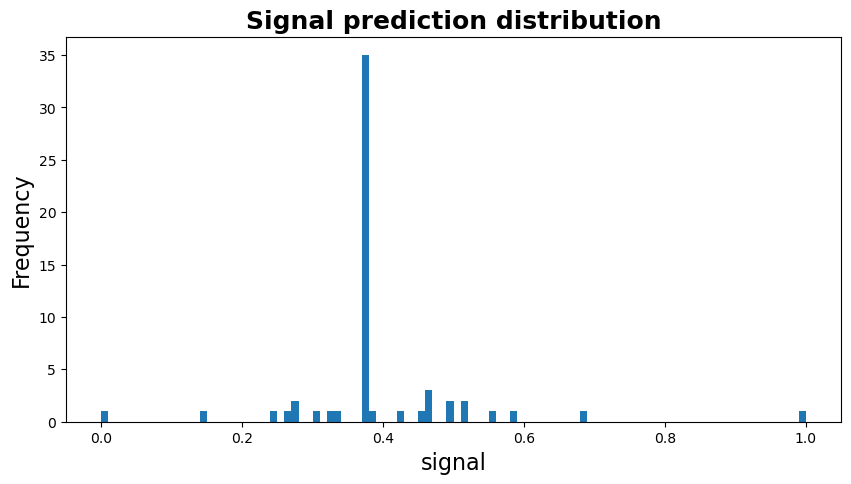

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Signal prediction distribution", weight='bold', fontsize=18)
plt.xlabel("signal", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
proc_data['signal'].plot(kind='hist', bins=100)


### Submission

Now that we have the predictions, we are almost ready to submit to Numerai Signals. To finalize the DataFrame a column is added indicating that the predictions are for "live" data (e.g. the upcoming week). Also, we make a date column denoting the upcoming Friday. Lastly, the DataFrame is written to CSV and uploaded using Numerai's API. 

In [ ]:
class SignalsSubmit:
    """ Submit class for Numerai Signals """

    def __init__(self, test_df: pd.DataFrame):
        self.test_df = test_df
        self.test_df.loc[:, "data_type"] = "live"
        last_friday = int(
            str((datetime.now() + relativedelta(weekday=FR(-1))).date()).replace("-", ""))
        self.test_df["friday_date"] = last_friday
        self.napi = numerapi.SignalsAPI(NMR_PUBLIC_ID, NMR_SECRET_KEY)

    def create_final_csv(self, path: str):
        """
        Create a csv for submission data

        :param path: Path which will be used to save the csv
        """
        cols = ["bloomberg_ticker", "friday_date", "data_type", "signal"]
        self.test_df[cols].reset_index(drop=True).to_csv(path, index=False)

    def _upload_predictions(self, model_id: str, path: str):
        """
        Upload the predictions with Numerapi

        :param path: The path from which to retrieve the CSV submission file
        :param model_id: Numerai model_id. Retrieved through calling napi.get_models()['MODEL_NAME']
        """
        print(f"Submitting for Numerai Signals")
        self.napi.upload_predictions(path, model_id=model_id)
        print(f"Submission of {path} is done!")

    def full_submission(self, model_name: str, path: str):
        """
        Create a final csv and upload the predictions to Numerai

        :param path: The path from which to retrieve the CSV submission file
        :param model_name: Model name on numerai signals
        """
        model_id = self.napi.get_models()[model_name]
        self.create_final_csv(path=path)
        self._upload_predictions(path=path, model_id=model_id)


In [ ]:
# Submit to Numerai Signals
s = SignalsSubmit(proc_data)
s.full_submission(model_name=MODEL_NAME, path=SUB_PATH)


KeyError: 'Compute'

### Final Check

In [ ]:
sub = pd.read_csv(SUB_PATH)
print(f"Submission shape: {sub.shape}")
print("First 5 rows:")
sub.head()


FileNotFoundError: [Errno 2] No such file or directory: 'finbert_submission.csv'

In [ ]:
print("Last 5 rows:")
sub.tail()


Last 5 rows:


,bloomberg_ticker,friday_date,data_type,signal
2009,APH US,20210312,live,0.499999
2010,EXPE US,20210312,live,0.999994
2011,MRTN US,20210312,live,0.499996
2012,DDD US,20210312,live,0.499995
2013,ATEC US,20210312,live,0.250399


That's it! I hope this notebook gave you inspiration to start with Numerai Signals and sentiment analysis! 

If you have any questions or feedback, feel free to comment below. You can also contact me on Twitter [@carlolepelaars](https://twitter.com/carlolepelaars).

In [ ]:
import json
raw_data['date'] = raw_data['date'].apply(lambda x: datetime.strptime(x, "%a, %d %b %Y %H:%M:%S %z"))


In [ ]:
from datetime import timedelta, timezone

sorted_data = raw_data.sort_values(by=['date'], ascending=False)
tz1 = timezone(timedelta(hours=9), 'Asia/Seoul')
sorted_data[sorted_data['date'] > (datetime.now().replace(tzinfo=tz1) - timedelta(days=7))]

,news_url,image_url,title,text,source_name,date,topics,sentiment,type,tickers
452,https://www.cnbc.com/2022/11/15/apple-to-buy-c...,https://cdn.snapi.dev/images/v1/g/w/107115114-...,Apple will buy processors from factory in Ariz...,If Apple were to buy processors manufactured i...,CNBC,2022-11-15 17:27:05-05:00,['CEO'],Neutral,Article,['AAPL']
3941,https://www.businessinsider.com/walmart-settle...,https://cdn.snapi.dev/images/v1/6/3/6373faa1ca...,Walmart to pay $3.1 billion to settle opioid l...,Walmart joins CVS and Walgreens in paying more...,Business Insider,2022-11-15 17:06:40-05:00,['paylimitwall'],Negative,Article,['WMT']
7501,https://www.cnbc.com/2022/11/15/microsoft-will...,https://cdn.snapi.dev/images/v1/o/q/107152153-...,Microsoft will update harassment policy after ...,Some people who filed harassment or discrimina...,CNBC,2022-11-15 16:47:40-05:00,[],Negative,Article,['MSFT']
7051,https://seekingalpha.com/article/4558155-novar...,https://cdn.snapi.dev/images/v1/p/j/image-1437...,Novartis: Limited Growth,We analyzed the latest Pharma conference with ...,Seeking Alpha,2022-11-15 16:43:47-05:00,['paylimitwall'],Positive,Article,['NVS']
2734,https://www.marketwatch.com/story/tesla-board-...,https://cdn.snapi.dev/images/v1/g/q/im-662583s...,Tesla board chair defends Elon Musk's pay pack...,"WILMINGTON, Del. — The head of Tesla's board o...",Market Watch,2022-11-15 16:41:00-05:00,"['CEO', 'paylimitwall']",Negative,Article,['TSLA']
...,...,...,...,...,...,...,...,...,...,...
6365,https://techcrunch.com/2022/11/09/meta-confirm...,https://cdn.snapi.dev/images/v1/g/e/gettyimage...,"Meta confirms 11,000 layoffs, amounting to 13%...","Facebook, Instagram, and WhatsApp's parent com...",TechCrunch,2022-11-09 06:26:35-05:00,['Layoffs'],Negative,Article,['META']
6316,https://techcrunch.com/2022/11/09/meta-confirm...,https://cdn.snapi.dev/images/v1/g/e/gettyimage...,"Meta confirms 11,000 layoffs, amounting to 13%...","Facebook, Instagram, and WhatsApp's parent com...",TechCrunch,2022-11-09 06:26:35-05:00,['Layoffs'],Negative,Article,['META']
6371,https://www.marketwatch.com/story/meta-to-lay-...,https://cdn.snapi.dev/images/v1/t/i/105155377-...,"Meta to lay off more than 11,000 employees, or...","Meta Platforms Inc. META, -0.26% Chief Executi...",Market Watch,2022-11-09 06:25:51-05:00,"['Layoffs', 'paylimitwall']",Negative,Article,['META']
6402,https://www.marketwatch.com/story/meta-to-lay-...,https://cdn.snapi.dev/images/v1/t/i/105155377-...,"Meta to lay off more than 11,000 employees, or...","Meta Platforms Inc. META, -0.26% Chief Executi...",Market Watch,2022-11-09 06:25:51-05:00,"['Layoffs', 'paylimitwall']",Negative,Article,['META']


In [ ]:
from redis import StrictRedis
redis = StrictRedis("findb.1cqguh.ng.0001.apn2.cache.amazonaws.com", 6379, 0, "")
print(redis.keys("*"))
for k, v in raw_data.iterrows():
    tk: list = json.loads(v["tickers"].replace("'", '"'))
    name: str = buy['ticker'].item()
    if name in tk:
        print(v)
